In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import re

# Feature extraction and visualization

Author: Tiago F. Tavares - 2016

This document contains a demonstration of a low-level feature extraction process. The main hypothesis behind this method is that perceptual audio characteristics are related to low-level features spectral features. Therefore, we first calculate a spectrogram for the audio file. Then, for each spectrogram frame, we calculate a descriptive feature. In the following example, we will calculate the spectral flux, which is the sum of the positive differences between two consecutive spectrogram frames:

In [49]:
import mir3.modules.tool.wav2spectrogram as spec
import mir3.modules.features.flux as flux

# Calculate spectrogram
converter = spec.Wav2Spectrogram()
s = converter.convert(open("examples/157447__nengisuls__solo-loops-2.wav"), window_length=2048, dft_length=2048,
            window_step=1024, spectrum_type='magnitude', save_metadata=True)

f = flux.Flux()

track = f.calc_track(s) # Feature track

The feature calculation generates a feature track. Like the spectrogram, it contains both *data* and *metadata* regarding the calculation. We can use it such information to plot the feature track, as:

In [34]:
def plot_feature_track(s, scale=None, dim=0, size=(3.45,2.0)):
    if s.data.ndim > 1:
        d = s.data[:,dim]
    else:
        d = s.data

    min_y = np.min(d)
    max_y = np.max(d)
    min_time = 0
    max_time = float(len(d)) / s.metadata.sampling_configuration.ofs

    ylabel = s.metadata.feature.split()[dim]
    if scale is not None:
        ylabel += ' ('
        ylabel += str(scale)
        ylabel += ')'

    x_axis = np.array(range(len(d))) / \
            float(s.metadata.sampling_configuration.ofs)

    im = plt.plot(x_axis, d)
    plt.xlabel('Time (s)')
    plt.ylabel(ylabel)
    fig = plt.gcf()
    width_inches = size[0]#/80.0
    height_inches = size[1]#/80.0
    fig.set_size_inches( (width_inches, height_inches) )
    plt.show()


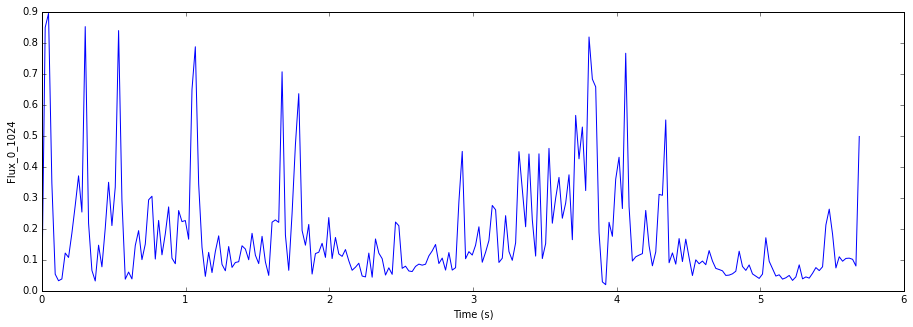

In [35]:
plot_feature_track(track, size=(15.45,5.0))

An important metadata member is *.feature*. It contains the label of the feature contained in the feature track. In this case, the *_0_1024* indicate that the feature was calculated using bins 0 to 1024 in the spectrogram.

PyMIR3 also provides tools for differentiating feature tracks. The *features.diff* module also generates a feature track, whose feature name is equal to the input feature name preceded by a *diff_* indicator:

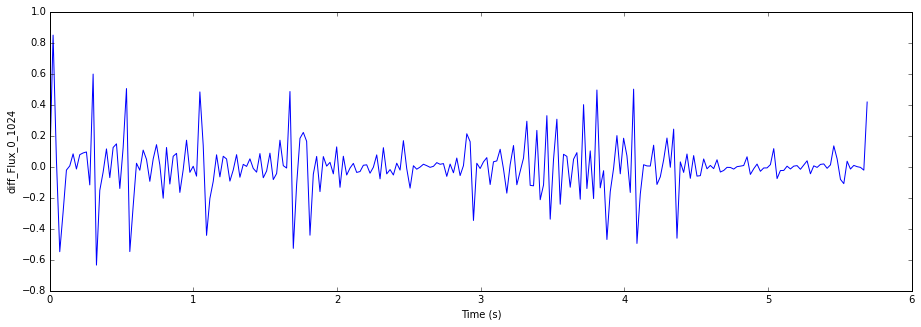

In [51]:
import mir3.modules.features.diff as diff

d = diff.Diff()
dtrack = d.calc_track(track)
plot_feature_track(dtrack, size=(15.45,5.0))

## Texture windows

Texture windows are sliding windows of approximately 1s in which feature statistics (mean and variance) are calculated. The low-pass characteristic of a texture window allows it to be used to detect low-level features at the *auditory texture* level. The texture window estimator also generates a feature track. However, the generated feature contains two dimensions, related to the mean and variance of the feature within the texture window:

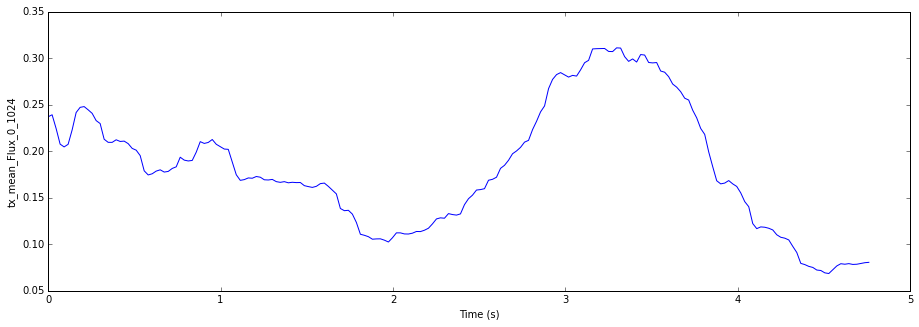

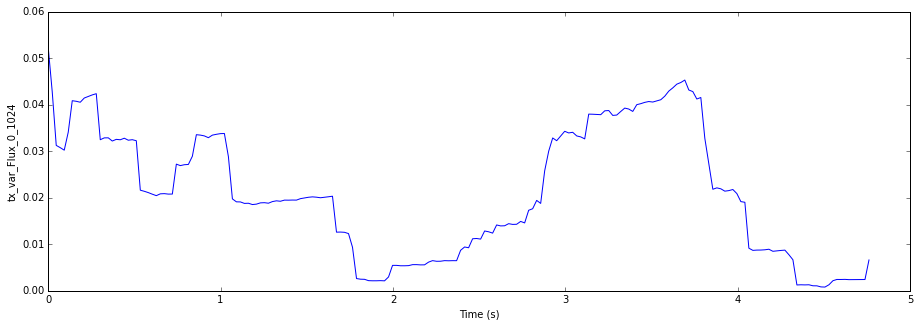

In [59]:
import mir3.modules.tool.to_texture_window as tex
reload(tex)
# Texture window
t = tex.ToTextureWindow().to_texture(track, 40)

plot_feature_track(t, dim=0, size=(15.45,5.0))
plot_feature_track(t, dim=1, size=(15.45,5.0))

## Joining many feature tracks in a single object

It is possible that you want to join all feature tracks from a particular file to a single object. The reasons for this are many: you may want to save it all at once, or perform further calculations all at once, or something else. PyMIR3 provides the *join* class to perform such operations:


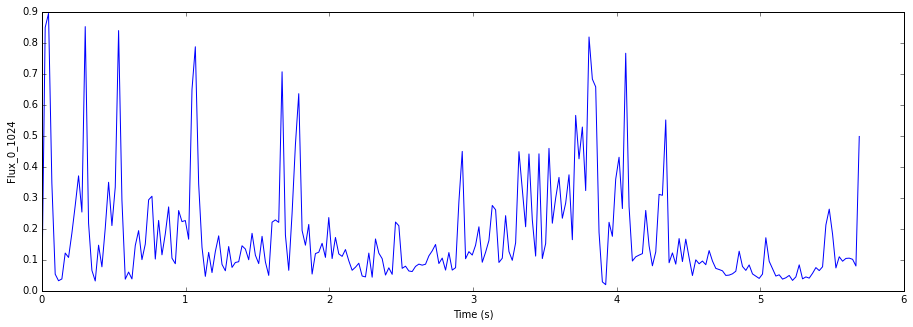

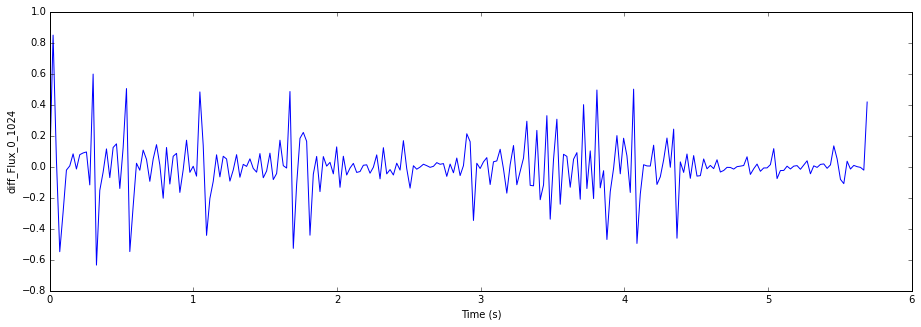

In [69]:
import mir3.modules.features.join as join

j = join.Join()
all_tracks = j.join([track, dtrack])
plot_feature_track(all_tracks, dim=0, size=(15.45,5.0))
plot_feature_track(all_tracks, dim=1, size=(15.45,5.0))


## Metadata preservation and tracing previous transformations

The following lines should be read as follows:
* The features held in *t* are ....
* The features held in the input of *t* are ....
* The filename used as input for the input of *t* is ....


In [74]:
print "Feature name:", t.metadata.feature
print "Input feature name:", t.metadata.input_metadata.feature
print "Input filename:", t.metadata.input_metadata.input_metadata.input.name

Feature name: tx_mean_Flux_0_1024 tx_var_Flux_0_1024
Input feature name: Flux_0_1024
Input filename: examples/157447__nengisuls__solo-loops-2.wav


If a feature track was built from many inputs, then *.input_metadata* will be a list:

In [73]:
print "Feature name:", all_tracks.metadata.feature
print "Input feature name:", all_tracks.metadata.input_metadata[0].feature
print "Input filename:", all_tracks.metadata.input_metadata[0].input_metadata.input.name

Feature name: Flux_0_1024 diff_Flux_0_1024
Input feature name: Flux_0_1024
Input filename: examples/157447__nengisuls__solo-loops-2.wav
